# Explainability of Neural Network Models for Time Series

## Notebook Overview
The aim is to identify and quantify the most relevant input features influencing model performance.

## Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import os
# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from dl_models import AutoencoderKfold as ae
from dl_models import LSTMKfold as lstm
from dl_models import AutoencoderLSTMKfold as ael
from utils import plots as plts
from utils import importance as im

In [2]:
# Time series data for all buildings
building_1_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")
building_2_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_2.csv")
building_3_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_3.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']


df1 = pd.concat([building_1_data, carbon_data, pricing_data, weather_data], axis=1)
# Concatenate the data from Building 2 and Building 3 vertically, creating a unified dataset for evaluation
building_2_3_data = pd.concat([building_2_data, building_3_data], axis=0, ignore_index=True)

# Combine carbon intensity, pricing, and weather data horizontally to align with building data
external_data = pd.concat([carbon_data, pricing_data, weather_data], axis=1)

# Repeat the external data (carbon, pricing, weather) to match the number of rows in Building 2 and 3 data
external_data_repeated = pd.concat([external_data] * 2, axis=0, ignore_index=True)

X_train = df1
X_test = pd.concat([building_2_3_data, external_data_repeated], axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train[features].values)
X_test_scaled = scaler.transform(X_test[features].values)

In [3]:
def create_lstm_input(data, timesteps):
    X_seq = []
    for i in range(len(data) - timesteps + 1):
        X_seq.append(data[i:i+timesteps])
    return np.array(X_seq)

def create_lstm_input_with_target(data, timesteps):
    X_seq, y = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X_seq), np.array(y)

## Phase 1: Identifying Important Features
- Use the best pre-trained models from the evaluation notebooks to test on the full feature set. For LSTM and Autoencoder-LSTM models, input data is first reshaped into sequences of fixed length (timesteps). 
- Compute permutation feature importance by measuring the increase in prediction/reconstruction error when permuting each feature.  
- Visualize feature importance using horizontal bar plots, with mean and standard deviation of error increases, normalized relative to the maximum value to allow easy comparison of the relative contribution of each feature.


In [4]:
model = load_model("..\\reports\\models\\autoencoder_generalization.h5")
means_ae, stds_ae = im.importance_autoencoder(model, X_test_scaled, features)
sorted_idx_ae = np.argsort(means_ae)

45/45 [==============================] - 0s 1ms/step


In [5]:
model = load_model("..\\reports\\models\\lstm_generalization.h5")
timesteps = 12
X_test_seq = create_lstm_input(X_test_scaled, timesteps=timesteps)
y_true = X_test_scaled[timesteps-1:, :]
means_lstm, stds_lstm = im.importance_lstm(model, X_test_seq, y_true, features)
sorted_idx_lstm = np.argsort(means_lstm)

45/45 [==============================] - 0s 2ms/step


In [6]:
model = load_model("..\\reports\\models\\autoencoderLSTM_generalization.h5")
timesteps = 6
X_test_seq = create_lstm_input(X_test_scaled, timesteps=timesteps)
means_aelstm, stds_aelstm = im.importance_autoencoder_lstm(model, X_test_seq, features)
sorted_idx_aelstm = np.argsort(means_aelstm)

45/45 [==============================] - 0s 5ms/step


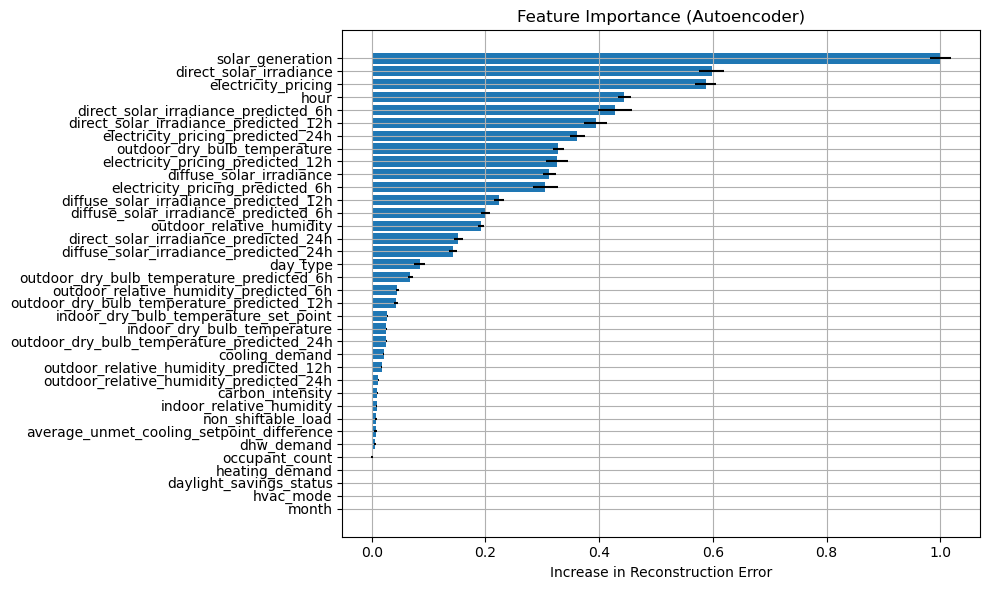

In [7]:
plts.plot_feature_importance(features, means_ae, stds_ae, title="Feature Importance (Autoencoder)", filename="autoencoder_importance.png")

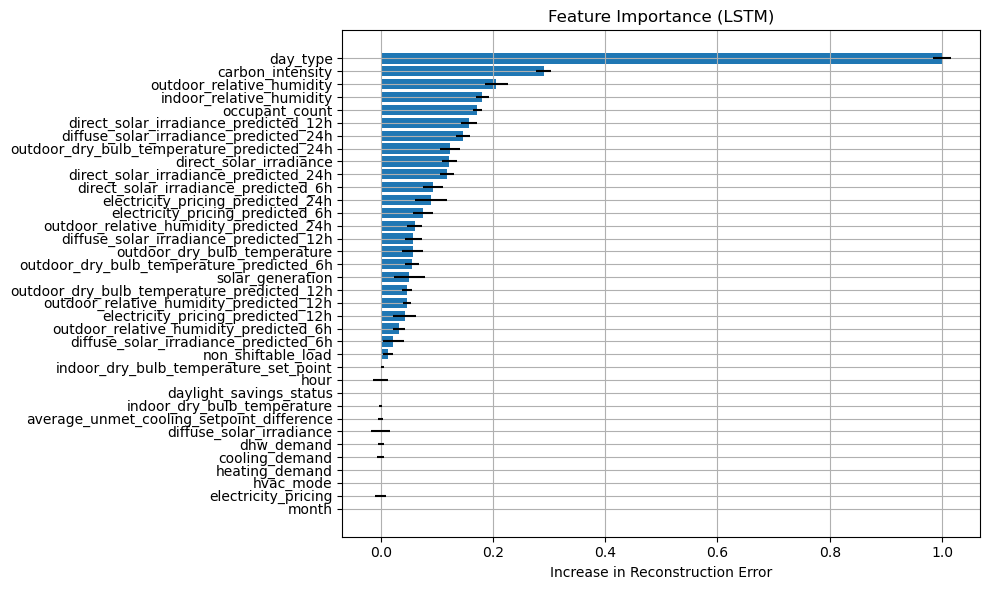

In [8]:
plts.plot_feature_importance(features, means_lstm, stds_lstm, title="Feature Importance (LSTM)", filename="lstm_importance.png")

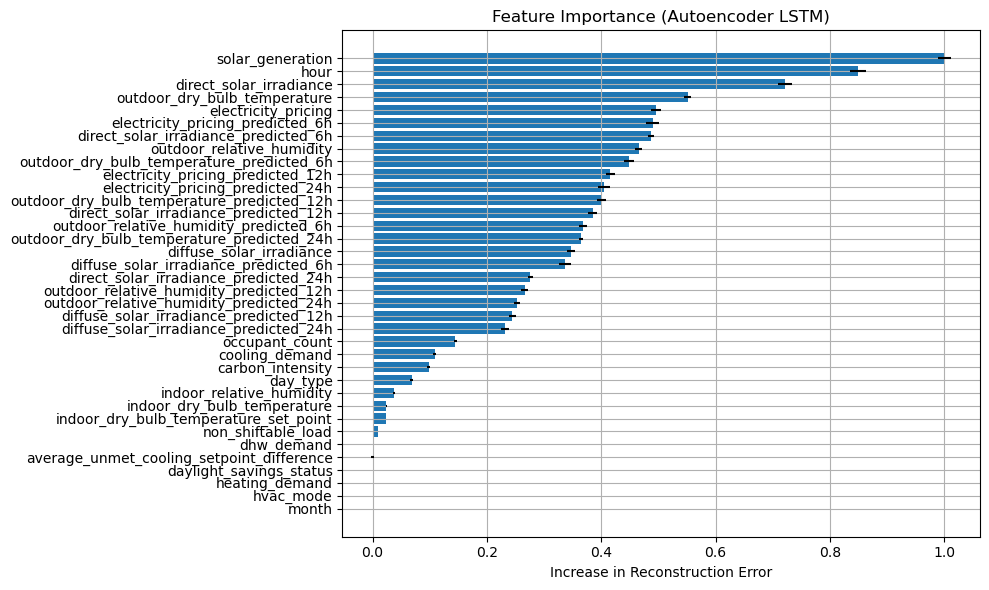

In [9]:
plts.plot_feature_importance(features, means_aelstm, stds_aelstm, title="Feature Importance (Autoencoder LSTM)", filename="autoencoderLSTM_importance.png")

## Phase 2: Training on Relevant Features
- Select features whose importance scores fall within the third and fourth quartiles, adding required target features if missing.  
- Prepare reduced datasets containing only these selected features.  
- Retrain models on the reduced datasets.  
- Compare prediction results with those obtained using the full feature set (see the generalization notebook).

In [10]:
q3 = np.percentile(means_ae, 75)
selected_features_ae = [f for f, m in zip(features, means_ae) if m >= q3]

for t in targets:
    if t not in selected_features_ae:
        selected_features_ae.append(t)

X_train_relevant_ae = X_train[selected_features_ae].copy()
X_test_relevant_ae = X_test[selected_features_ae].copy()

In [11]:
q3 = np.percentile(means_lstm, 75)
selected_features_lstm = [f for f, m in zip(features, means_lstm) if m >= q3]

for t in targets:
    if t not in selected_features_lstm:
        selected_features_lstm.append(t)

X_train_relevant_lstm = X_train[selected_features_lstm].copy()
X_test_relevant_lstm = X_test[selected_features_lstm].copy()

In [12]:
q3 = np.percentile(means_aelstm, 75)
selected_features_ael = [f for f, m in zip(features, means_aelstm) if m >= q3]

for t in targets:
    if t not in selected_features_ael:
        selected_features_ael.append(t)

X_train_relevant_ael = X_train[selected_features_ael].copy()
X_test_relevant_ael = X_test[selected_features_ael].copy()

In [13]:
real_ae, pred_ae, model_ae = ae.Autoencoder(train_df=X_train_relevant_ae, test_df=X_test_relevant_ae, features=selected_features_ae, epochs = 600, latent_dim = 128, batch_size = 32)

Epoch 1/600
23/23 [==============================] - 1s 5ms/step - loss: 0.1141 - mean_absolute_error: 0.3031
Epoch 2/600
23/23 [==============================] - 0s 5ms/step - loss: 0.0643 - mean_absolute_error: 0.2064
Epoch 3/600
23/23 [==============================] - 0s 5ms/step - loss: 0.0431 - mean_absolute_error: 0.1585
Epoch 4/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0310 - mean_absolute_error: 0.1354
Epoch 5/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0208 - mean_absolute_error: 0.1084
Epoch 6/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0149 - mean_absolute_error: 0.0905
Epoch 7/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0119 - mean_absolute_error: 0.0791
Epoch 8/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0099 - mean_absolute_error: 0.0706
Epoch 9/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0646
Epoch 10/6

In [14]:
real_lstm, pred_lstm, model_lstm = lstm.lstm_forecast(train_df=X_train_relevant_lstm, test_df=X_test_relevant_lstm, features=selected_features_lstm, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)

Epoch 1/150
45/45 - 2s - loss: 0.0612 - 2s/epoch - 35ms/step
Epoch 2/150
45/45 - 0s - loss: 0.0217 - 152ms/epoch - 3ms/step
Epoch 3/150
45/45 - 0s - loss: 0.0166 - 145ms/epoch - 3ms/step
Epoch 4/150
45/45 - 0s - loss: 0.0138 - 159ms/epoch - 4ms/step
Epoch 5/150
45/45 - 0s - loss: 0.0122 - 143ms/epoch - 3ms/step
Epoch 6/150
45/45 - 0s - loss: 0.0114 - 144ms/epoch - 3ms/step
Epoch 7/150
45/45 - 0s - loss: 0.0107 - 160ms/epoch - 4ms/step
Epoch 8/150
45/45 - 0s - loss: 0.0101 - 152ms/epoch - 3ms/step
Epoch 9/150
45/45 - 0s - loss: 0.0105 - 148ms/epoch - 3ms/step
Epoch 10/150
45/45 - 0s - loss: 0.0100 - 160ms/epoch - 4ms/step
Epoch 11/150
45/45 - 0s - loss: 0.0097 - 148ms/epoch - 3ms/step
Epoch 12/150
45/45 - 0s - loss: 0.0096 - 151ms/epoch - 3ms/step
Epoch 13/150
45/45 - 0s - loss: 0.0094 - 148ms/epoch - 3ms/step
Epoch 14/150
45/45 - 0s - loss: 0.0090 - 155ms/epoch - 3ms/step
Epoch 15/150
45/45 - 0s - loss: 0.0091 - 163ms/epoch - 4ms/step
Epoch 16/150
45/45 - 0s - loss: 0.0090 - 163ms/epoc

In [15]:
real_ael, pred_ael, model_ael = ael.Autoencoder(train_df=X_train_relevant_ael, test_df=X_test_relevant_ael, features=selected_features_ael, epochs = 300, batch_size = 32, latent_dim = 64, timesteps = 6)

Epoch 1/300
23/23 [==============================] - 2s 37ms/step - loss: 0.1495
Epoch 2/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0747
Epoch 3/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0453
Epoch 4/300
23/23 [==============================] - 1s 35ms/step - loss: 0.0301
Epoch 5/300
23/23 [==============================] - 1s 39ms/step - loss: 0.0222
Epoch 6/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0188
Epoch 7/300
23/23 [==============================] - 1s 33ms/step - loss: 0.0165
Epoch 8/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0150
Epoch 9/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0140
Epoch 10/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0131
Epoch 11/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0122
Epoch 12/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0115
Epoch 13/300
23/23 [=====

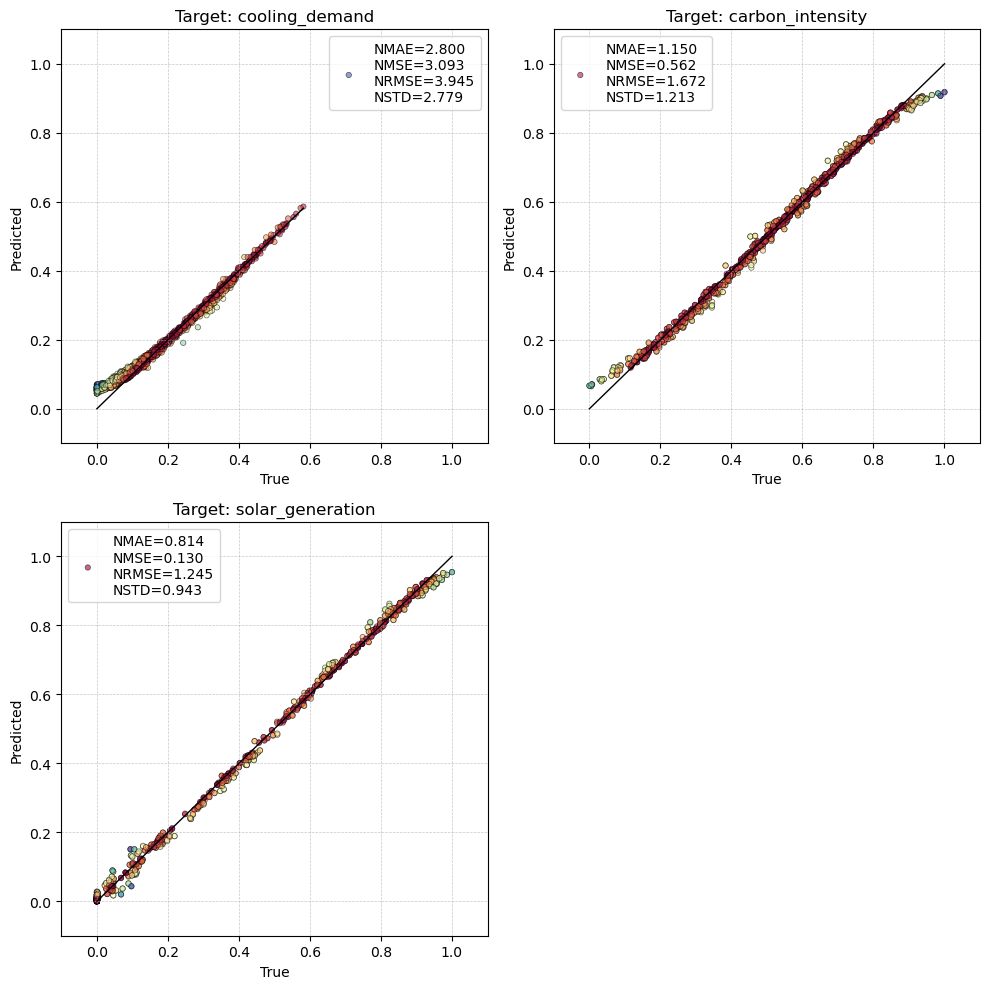

In [16]:
plts.plot_targets(real_ae, pred_ae, targets, selected_features_ae, percent=True, filename="autoencoder_relevant.png")

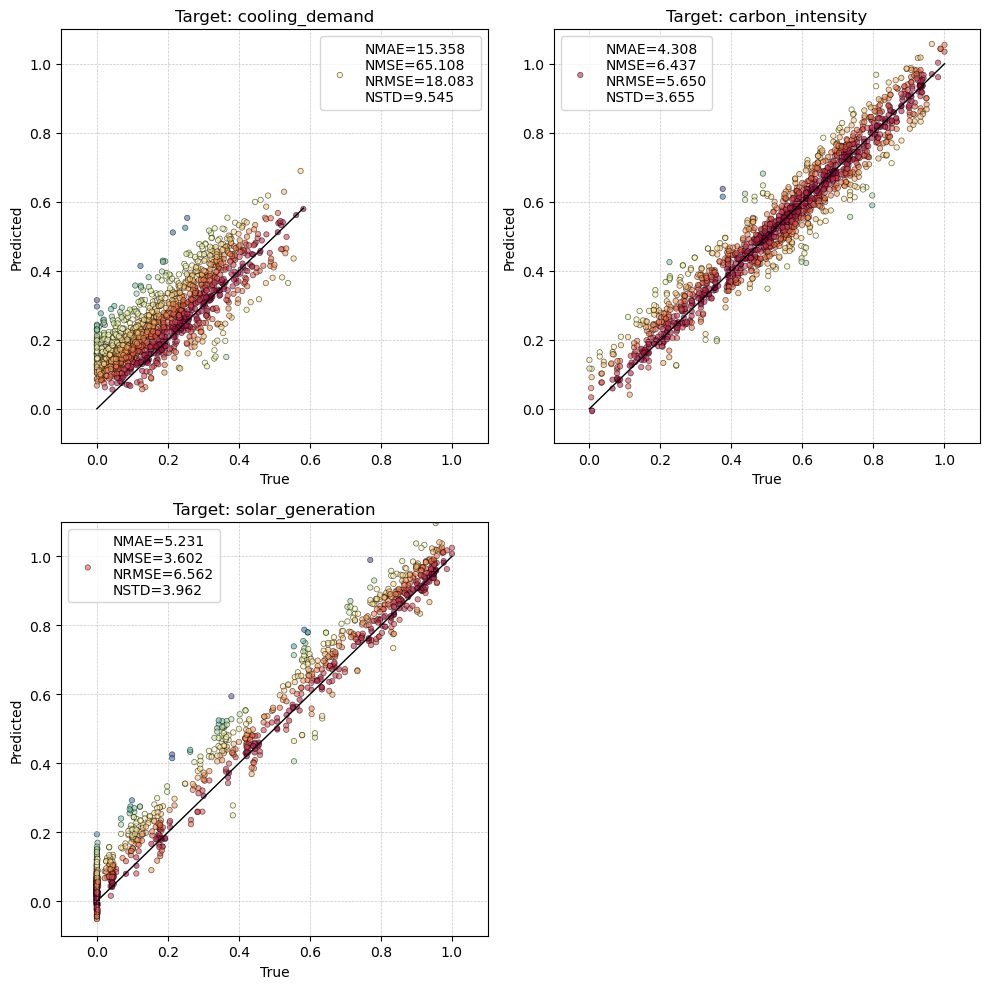

In [17]:
plts.plot_targets(real_lstm, pred_lstm, targets, selected_features_lstm, percent=True, filename="lstm_relevant.png")

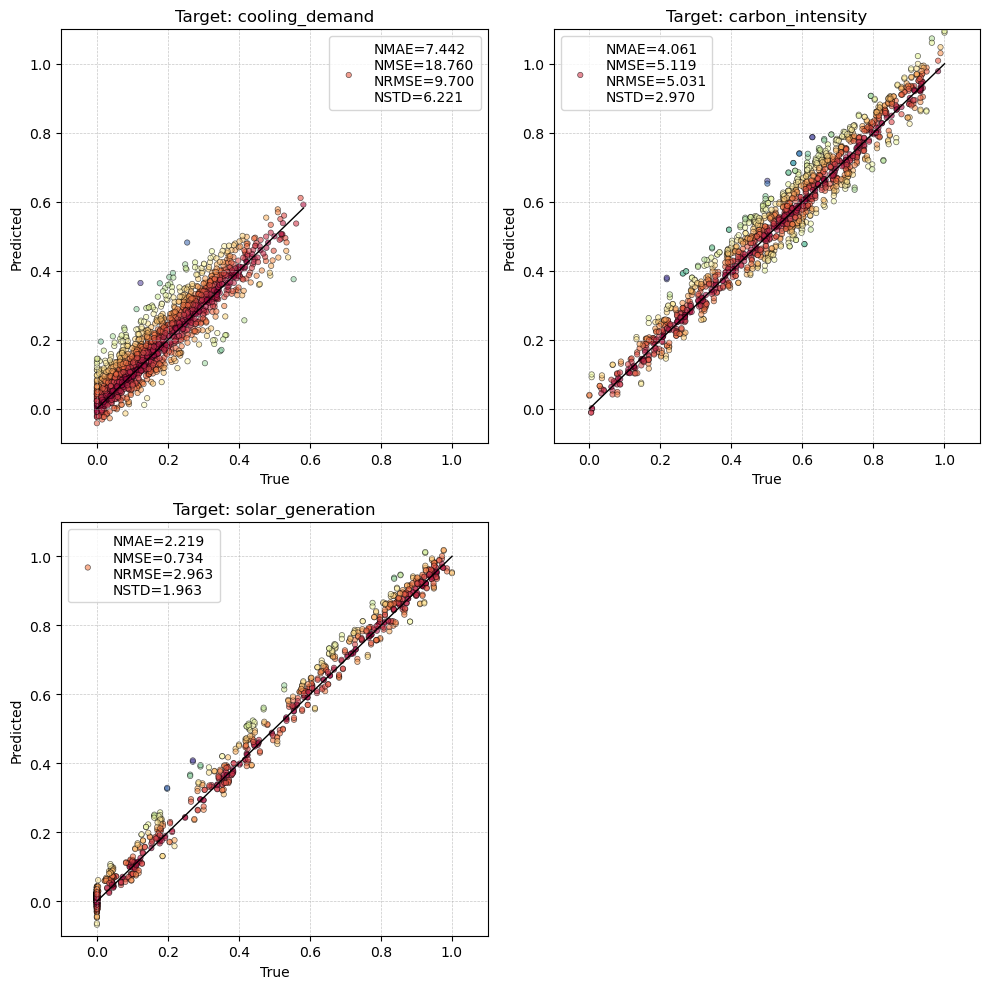

In [18]:
plts.plot_aelstm_targets(real_ael, pred_ael, targets, selected_features_ael, percent=True, filename="autoencoderLSTM_relevant.png")

## Extra: Recursive Feature Elimination with Cross Validation (RFECV)

RFECV will be applied as an additional feature selection method.  
A baseline model is used to iteratively remove the least important features, while cross validation evaluates model performance at each step.  

**Outputs**  
- Optimal number of features.  
- Selected feature subset.  
- Performance curve vs. number of features.

**Integration**  
The selected features will be used to build reduced datasets and retrain the main models, enabling performance comparison with the full feature set.

In [19]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42)
cv = TimeSeriesSplit(n_splits=5)

rfecv = RFECV(
    estimator=estimator,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error", 
    n_jobs=-1
)

X_train_ = X_train.drop(columns=targets)
y_train_ = X_train[targets] 

In [20]:
rfecv.fit(X_train_, y_train_)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
      scoring='neg_mean_squared_error')

In [21]:
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(X_train_.columns[rfecv.support_]))

Optimal number of features: 7
Selected features: ['hour', 'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_12h']


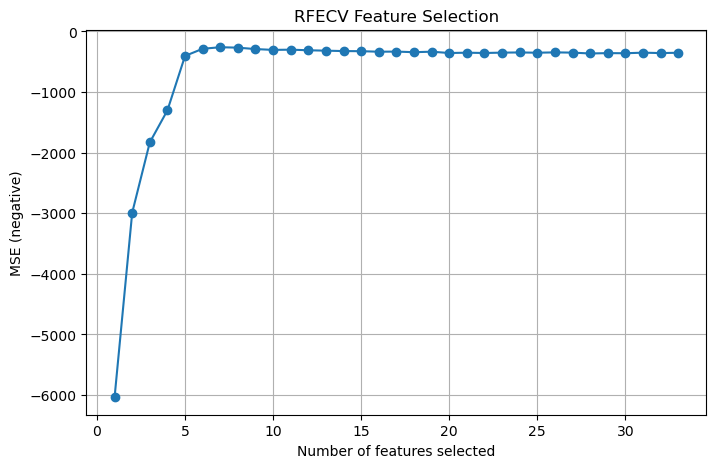

In [22]:
plts.plot_rfecv(rfecv, filename="rfecv.png") # RFECV expects higher scores to be better, so we use negative MSE.

In [23]:
selected_features_rfecv = list(X_train_.columns[rfecv.support_])
for t in targets:
    if t not in selected_features_rfecv:
        selected_features_rfecv.append(t)
X_train_rfecv = X_train.loc[:, selected_features_rfecv].copy()
X_test_rfecv = X_test.loc[:, selected_features_rfecv].copy()

In [24]:
real_ae_rfecv, pred_ae_rfecv, model_ae = ae.Autoencoder(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 600, latent_dim = 128, batch_size = 32)

Epoch 1/600
23/23 [==============================] - 1s 5ms/step - loss: 0.0824 - mean_absolute_error: 0.2515
Epoch 2/600
23/23 [==============================] - 0s 5ms/step - loss: 0.0392 - mean_absolute_error: 0.1660
Epoch 3/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0238 - mean_absolute_error: 0.1207
Epoch 4/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0172 - mean_absolute_error: 0.1003
Epoch 5/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0842
Epoch 6/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0102 - mean_absolute_error: 0.0750
Epoch 7/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0085 - mean_absolute_error: 0.0684
Epoch 8/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0640
Epoch 9/600
23/23 [==============================] - 0s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0604
Epoch 10/6

In [25]:
real_lstm_rfecv, pred_lstm_rfecv, model_lstm_rfecv = lstm.lstm_forecast(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 150, hidden_units = 16, batch_size = 16, timesteps = 3)

Epoch 1/150
45/45 - 1s - loss: 0.0622 - 1s/epoch - 29ms/step
Epoch 2/150
45/45 - 0s - loss: 0.0187 - 164ms/epoch - 4ms/step
Epoch 3/150
45/45 - 0s - loss: 0.0144 - 154ms/epoch - 3ms/step
Epoch 4/150
45/45 - 0s - loss: 0.0123 - 156ms/epoch - 3ms/step
Epoch 5/150
45/45 - 0s - loss: 0.0106 - 148ms/epoch - 3ms/step
Epoch 6/150
45/45 - 0s - loss: 0.0097 - 148ms/epoch - 3ms/step
Epoch 7/150
45/45 - 0s - loss: 0.0091 - 147ms/epoch - 3ms/step
Epoch 8/150
45/45 - 0s - loss: 0.0088 - 153ms/epoch - 3ms/step
Epoch 9/150
45/45 - 0s - loss: 0.0087 - 154ms/epoch - 3ms/step
Epoch 10/150
45/45 - 0s - loss: 0.0082 - 155ms/epoch - 3ms/step
Epoch 11/150
45/45 - 0s - loss: 0.0081 - 160ms/epoch - 4ms/step
Epoch 12/150
45/45 - 0s - loss: 0.0077 - 164ms/epoch - 4ms/step
Epoch 13/150
45/45 - 0s - loss: 0.0076 - 159ms/epoch - 4ms/step
Epoch 14/150
45/45 - 0s - loss: 0.0076 - 145ms/epoch - 3ms/step
Epoch 15/150
45/45 - 0s - loss: 0.0078 - 154ms/epoch - 3ms/step
Epoch 16/150
45/45 - 0s - loss: 0.0073 - 144ms/epoc

In [26]:
real_ael_rfecv, pred_ael_rfecv, model_ael_rfecv = ael.Autoencoder(train_df=X_train_rfecv, test_df=X_test_rfecv, features=selected_features_rfecv, epochs = 300, batch_size = 32, latent_dim = 64, timesteps = 6)

Epoch 1/300
23/23 [==============================] - 2s 30ms/step - loss: 0.1546
Epoch 2/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0666
Epoch 3/300
23/23 [==============================] - 1s 38ms/step - loss: 0.0402
Epoch 4/300
23/23 [==============================] - 1s 39ms/step - loss: 0.0253
Epoch 5/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0181
Epoch 6/300
23/23 [==============================] - 1s 32ms/step - loss: 0.0142
Epoch 7/300
23/23 [==============================] - 1s 34ms/step - loss: 0.0117
Epoch 8/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0101
Epoch 9/300
23/23 [==============================] - 1s 36ms/step - loss: 0.0091
Epoch 10/300
23/23 [==============================] - 1s 37ms/step - loss: 0.0085
Epoch 11/300
23/23 [==============================] - 1s 28ms/step - loss: 0.0079
Epoch 12/300
23/23 [==============================] - 1s 38ms/step - loss: 0.0076
Epoch 13/300
23/23 [=====

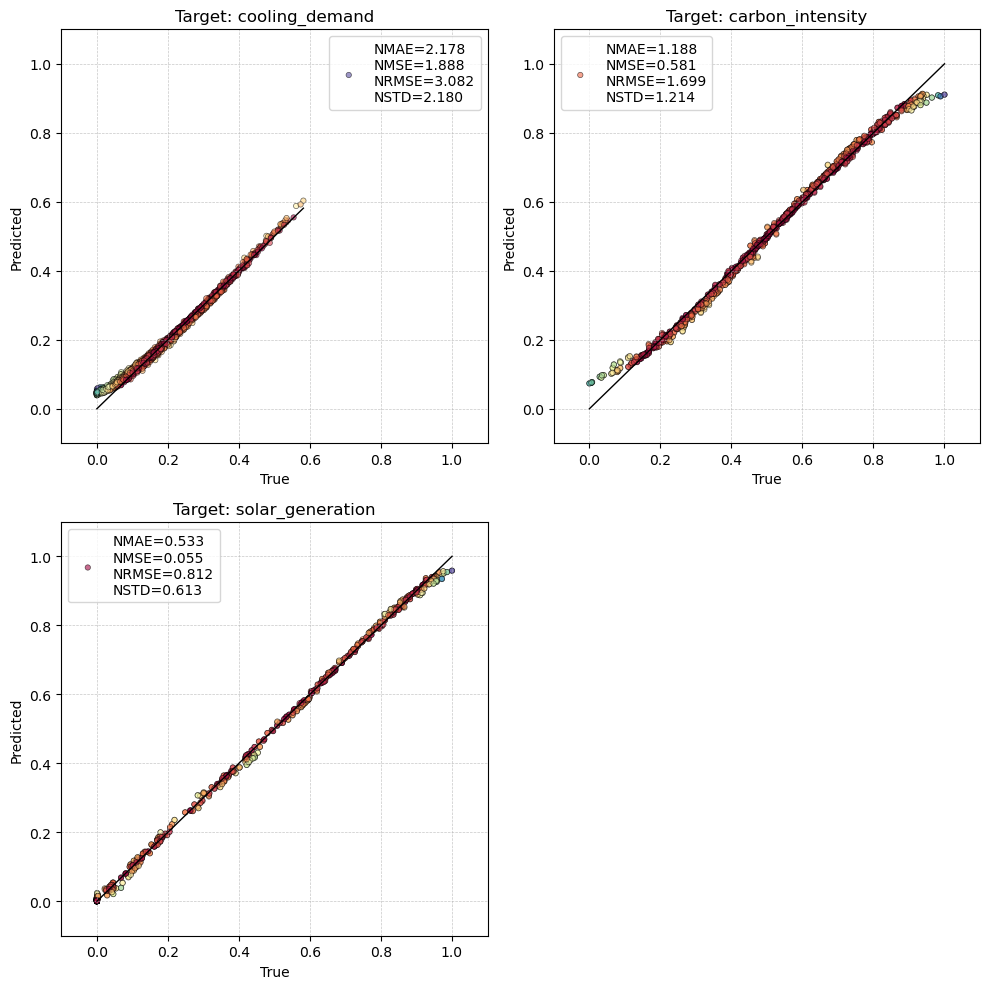

In [27]:
plts.plot_targets(real_ae_rfecv, pred_ae_rfecv, targets, list(selected_features_rfecv), percent=True, filename="autoencoder_rfecv.png")

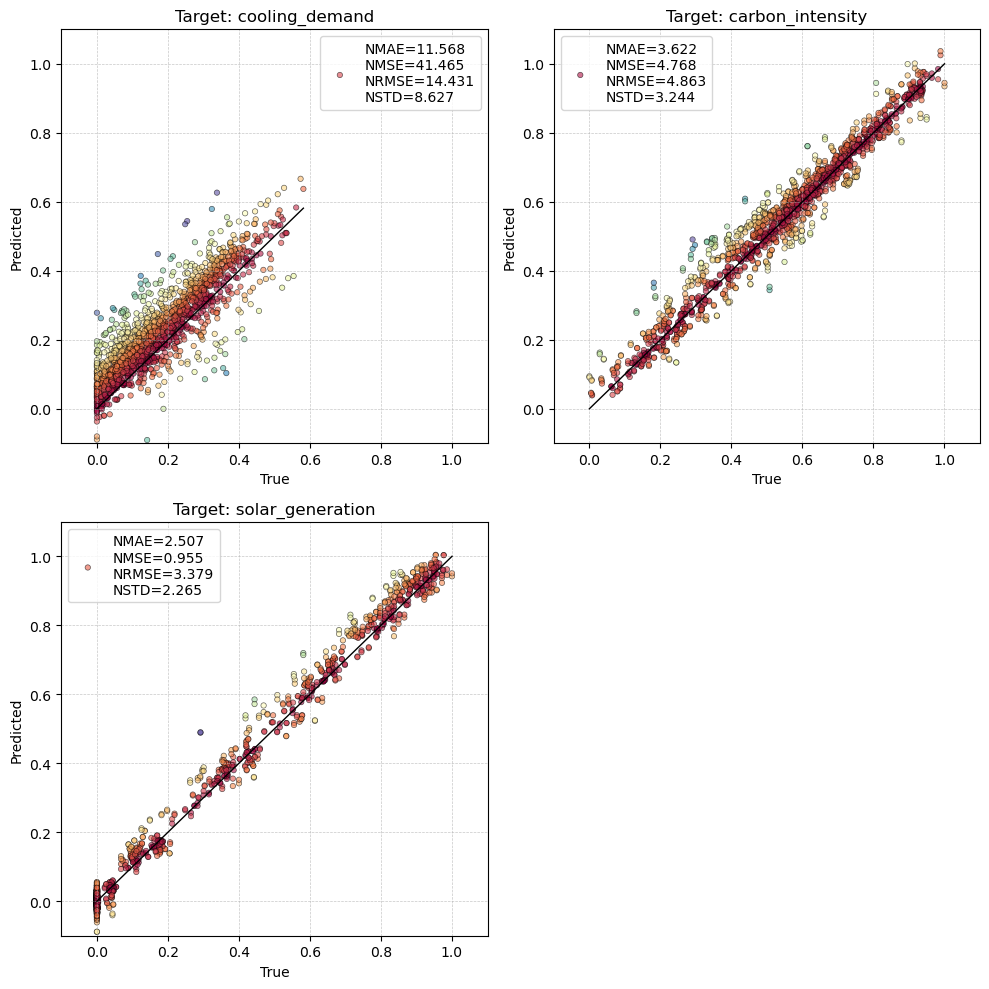

In [28]:
plts.plot_targets(real_lstm_rfecv, pred_lstm_rfecv, targets, selected_features_rfecv, percent=True, filename="lstm_rfecv.png")

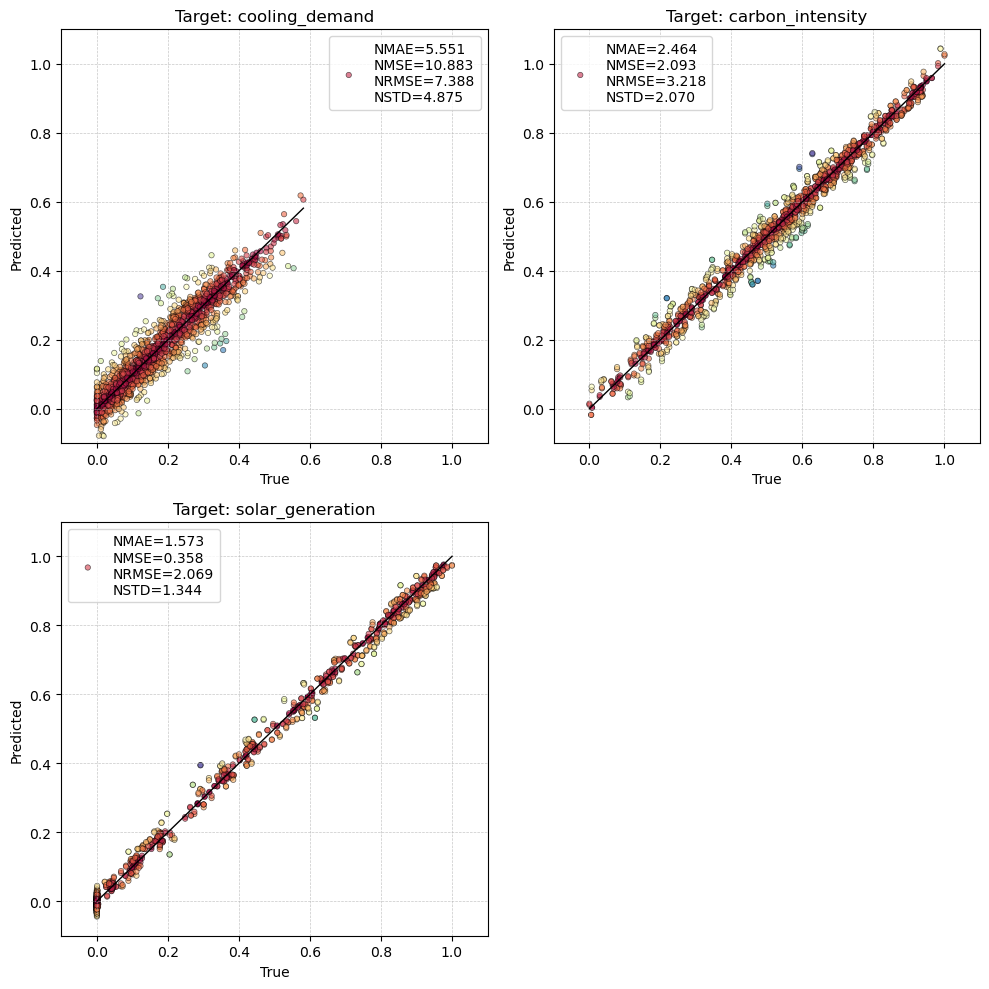

In [29]:
plts.plot_aelstm_targets(real_ael_rfecv, pred_ael_rfecv, targets, selected_features_rfecv, percent=True, filename="autoencoderLSTM_rfecv.png")